# Is Hip-Hop Unique? And is Eminem Unique?

In [263]:
# from IPython.display import Image
# Image(filename='../figs/hiphop.jpg')

![Hiphop](https://i.pinimg.com/originals/29/a0/d9/29a0d9f43e2cad8bf4d360f812449abb.jpg)

In [166]:
import numpy as np
import pandas as pd
import pyreadr
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import cv2
from nltk.corpus import stopwords

"""
Load processed lyrics data
"""

def read_processed_lyrics() -> pd.DataFrame:
    """
    Load processed lyrics data from file
    
    return the data frame containing the data
    """
    result = pyreadr.read_r('../output/processed_lyrics.RData')
    return result['dt_lyrics']

lyrics_df = read_processed_lyrics()

In [232]:
"""
Check null value
"""
lyrics_df.info()

# lyrics_df.describe()

lyrics_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125704 entries, 0 to 125703
Data columns (total 8 columns):
song            125704 non-null object
year            125704 non-null float64
artist          125704 non-null object
genre           125704 non-null object
lyrics          125704 non-null object
id              125704 non-null int32
stemmedwords    125704 non-null object
word_count      125704 non-null int64
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 7.2+ MB


,song,year,artist,genre,lyrics,id,stemmedwords,word_count
0,when-you-were-with-me,2009.0,a,Hip-Hop,I stopped by the house we called our home\nIt ...,1,stop house call home rundown grass overgrown s...,25
1,careless-whisper,2009.0,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...,2,unsure hand lead dance floor music die eyes ca...,92
2,2-59,2007.0,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,3,mark sunday football boots pitch people gamble...,108
3,power-of-desire,2007.0,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...,4,chris fallin fantasy threw destiny stop feelin...,53
4,you-re-not-in-love,2007.0,a,Hip-Hop,something in the way we touch\nyou hold my han...,5,touch hold hand hold somethings change somethi...,41


## Data Cleaning

In [169]:
"""
Correct wrong year value
"""
lyrics_df.loc[64356,'year'] = 2002
lyrics_df.loc[91130,'year'] = 1999

In [170]:
"""
Counting the number of tokens in each song
"""
def words_count(raw_text):
    return len(raw_text.split())
lyrics_df['word_count'] = lyrics_df['stemmedwords'].apply(words_count)
lyrics_df.describe()

,year,id,word_count
count,125704.000000,125704.000000,125704.000000
mean,2006.823625,62858.362892,75.714202
std,5.530243,36291.223577,56.711070
min,1968.000000,1.000000,2.000000
25%,2006.000000,31428.750000,43.000000
50%,2007.000000,62859.500000,61.000000
75%,2008.000000,94287.250000,89.000000
max,2016.000000,125715.000000,2440.000000


In [155]:
"""
Get rid of outliers in terms of word count.
Here we remove all songs with word_count > 1000 and word_count < 100
"""
lyrics_df = lyrics_df[lyrics_df['word_count'] >= 100]
lyrics_df = lyrics_df[lyrics_df['word_count'] <= 1000]
lyrics_df.describe()

,year,id,word_count
count,24088.000000,24088.000000,24088.000000
mean,2007.428678,63274.473431,161.536782
std,5.221230,35136.066215,72.501818
min,1970.000000,3.000000,100.000000
25%,2006.000000,33848.500000,112.000000
50%,2007.000000,62004.000000,133.000000
75%,2010.000000,93077.250000,187.000000
max,2016.000000,125706.000000,970.000000


1. Trend of words
    1. Overall trend
    2. Trend in Hip-Hop
2. Difference between Hip-hop and other genres
    1. word cloud
    2. sentiment analysis
    3. profane words(optional)
3. Is Eminem unique?
    1. 根据词云图，判断他 vs 其他hiphop 歌手的词
    2. 他歌词中 unique 词的数量 vs 其他
    3. 他歌词中词的总数 vs 其他平均歌词的总数 --> 平均语速
    

## Question1. Does the trend of words change with time?

In [251]:
"""
Get all lyrics for each decades

store the lyrics string for all genre and only Hip-Hop

"""
def get_subdata_by_period(dataframe, start_year, end_year, genre) -> pd.DataFrame:
    """
    return the subset of dataframe whose 'year' are in the range 
    from 'start_year'(inclusive) to 'end_year'(exclusive)
    """
    start_condition = dataframe['year'] >= start_year if start_year else True
    end_condition = dataframe['year'] < end_year if end_year else True
    genre_condition = True if genre is None or genre == 'all' else dataframe['genre'] == genre
#     print(sum(genre_condition))
    return dataframe[start_condition & end_condition & genre_condition]
    
    
def combine_stemmed_lyrics(dataframe) -> str:
    """
    return a string that contains all stemmed lyrics of the dataframe
    """
    lyrics_list = []

    for index, row in dataframe.iterrows():
        lyrics_list.append(row['stemmedwords'])
    return " ".join(lyrics_list)


def get_lyrics_by_decades(genre = None):
    """
    return a dictionary containing all lyrics as strings
    the key is decade, value is the lyrics string
    
    if genre is None or 'all', then the lyrics containing lyrics for all genre
    otherwise it's only from a specific genere
    """
    lyrics_dict = {}
    lyrics_dict["70"] = combine_stemmed_lyrics(get_subdata_by_period(lyrics_df,None, 1980, genre))
    lyrics_dict["80"] = combine_stemmed_lyrics(get_subdata_by_period(lyrics_df,1980, 1990, genre))
    lyrics_dict["90"] = combine_stemmed_lyrics(get_subdata_by_period(lyrics_df,1990, 2000, genre))
    lyrics_dict["00"] = combine_stemmed_lyrics(get_subdata_by_period(lyrics_df,2000, 2010, genre))
    lyrics_dict["10"] = combine_stemmed_lyrics(get_subdata_by_period(lyrics_df,2010, None, genre))
    return lyrics_dict

lyrics_dict_all = get_lyrics_by_decades(genre = 'all')
lyrics_dict_hiphop = get_lyrics_by_decades(genre = 'Hip-Hop')


In [296]:
def get_stopwords():
    """
    return a 'set' containing all stop words
    """
    english_stopwords =set(stopwords.words('english')) | STOPWORDS | ENGLISH_STOP_WORDS | set(['a','yeah', 'ah', 'aa', 'aaa','aaaa'])
    english_stopwords.add('youre')
    english_stopwords.add('ill')
    english_stopwords.add('youll')
    english_stopwords.add('ive')
    english_stopwords.add('youve')
    english_stopwords.add('shes')
    english_stopwords.add('hes')
    english_stopwords.add('ya')
    english_stopwords.add('yo')
    english_stopwords.add('em')
    return english_stopwords

# def generate_pattern_image(image_shape_text):# Create a black image
#     """
#     create a black image for the shape of word cloud
#     """
#     cnt = len(image_shape_text)
#     img = np.zeros((612,cnt*420*3,3), np.uint8)
    
#     # Write some Text
#     font = cv2.FONT_HERSHEY_TRIPLEX
#     cv2.putText(img,image_shape_text,(0,500), font, 20,(255,255,255), 80)
#     img = 255-img
#     #Save image
#     # cv2.imwrite("out.jpg", img)
#     return img

def draw_wordCloud(natural_text, title):
    """
    """
    # stop words
    english_stopwords = get_stopwords()
    # generate wordcloud
    wordcloud = WordCloud(background_color ='white', max_words=50, 
                          stopwords=english_stopwords,
                          collocations=False
                         ).generate(natural_text)
                
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, size=30)
    plt.show()

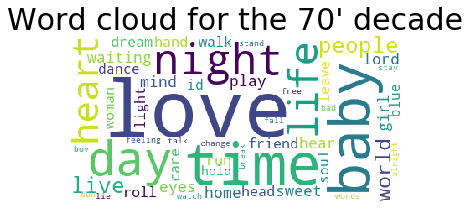

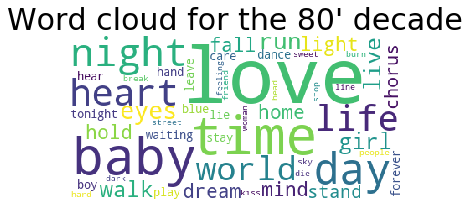

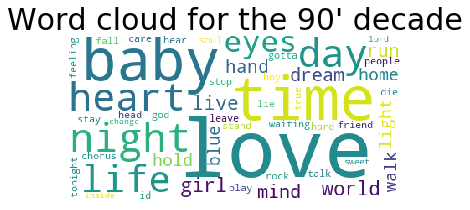

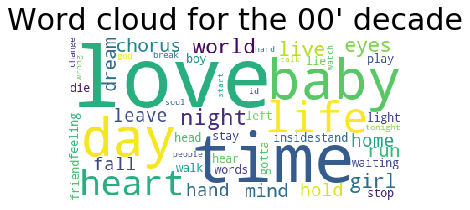

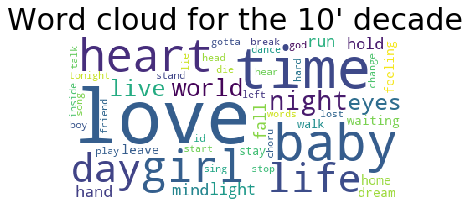

In [297]:
"""
word cloud plot for all genres
"""

decades = ['70','80','90','00', '10']
title_template = "Word cloud for the {0}' decade"
for dec in decades:
    draw_wordCloud(lyrics_dict_all[dec], title = title_template.format(dec))


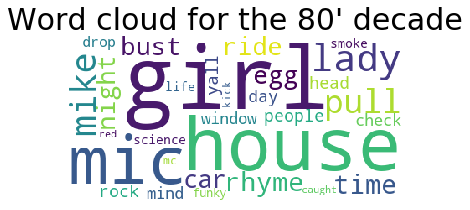

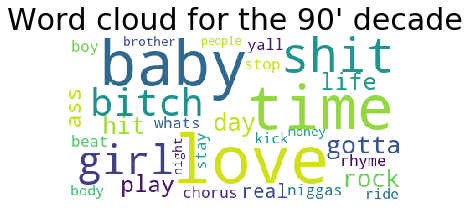

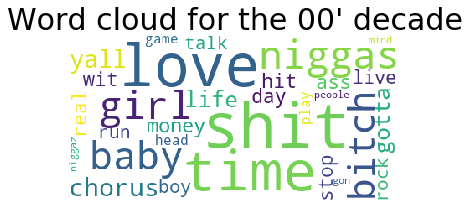

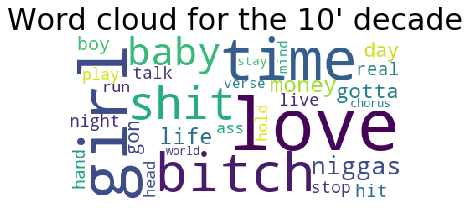

In [260]:
"""
word cloud plot for Hip-Hop
"""
decades = ['80','90','00', '10']
title_template = "Word cloud for the {0}' decade"
for dec in decades:
    draw_wordCloud(lyrics_dict_hiphop[dec], title = title_template.format(dec))


## Question2. Are there any differences between Hip-hop and other genres?

### Part1. Word Analysis

In [298]:
lyrics_hiphop = combine_stemmed_lyrics(lyrics_df[lyrics_df['genre'] == 'Hip-Hop'])
lyrics_non_hiphop = combine_stemmed_lyrics(lyrics_df[lyrics_df['genre'] != 'Hip-Hop'])

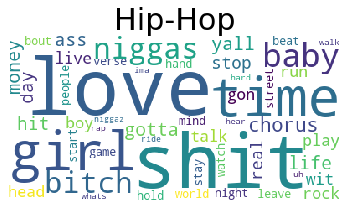

In [300]:
draw_wordCloud(lyrics_hiphop, title = 'Hip-Hop')

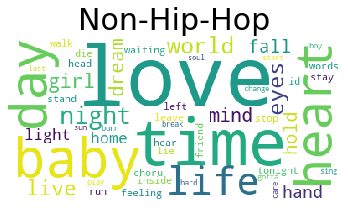

In [301]:
draw_wordCloud(lyrics_non_hiphop, title = "Non-Hip-Hop")

### Part2. Profanity Word Frequency

### Part3. Sentiment Analaysis

## Question3. Is Eminem unique?

![](https://images-na.ssl-images-amazon.com/images/I/51WGb8pCIVL._SY679_.jpg)

1. 根据词云图，判断他 vs 其他hiphop 歌手的词
2. 他歌词中 unique 词的数量 vs 其他
3. 他歌词中词的总数 vs 其他平均歌词的总数 --> 平均语速